# Speech Recognition using the TIMIT dataset

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from IPython.core.debugger import set_trace
from IPython.display import Audio, display
import sys
sys.path.append("../..")

from audio import *
import librosa
import librosa.display
from fastai import *
from audio import *
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

np.random.seed(2)

In [3]:
path = Path("/data/stt/data/timit")
path_train_df = path/"train_data.csv"
path_valid_df = path/"test_data.csv"
path_train = "TRAIN"
path_valid = "TEST"
bs = 16

## Data analysis

In [4]:
one_file = path/"TRAIN/DR1/FCJF0/SI1657.WAV.wav"
aud, sr = librosa.load(one_file, sr=None)
aud, sr

(array([1.220703e-04, 9.155273e-05, 1.831055e-04, 6.103516e-05, ..., 9.155273e-05, 9.155273e-05, 1.220703e-04,
        1.220703e-04], dtype=float32), 16000)

In [5]:
display(Audio(aud, rate=sr))

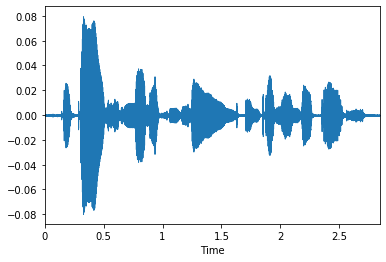

In [6]:
_ = librosa.display.waveplot(aud, sr)

## load dataset

In [7]:
def label_func(fn):
    sp = str(fn).split("/")
    last_n = sp[-4:]
    joined = "/".join(last_n)
    
    # get path to the label file
    is_train = sp[0] == "TRAIN"
    fname = sp[-1].split(".")[0]
    label_file = "/".join([*sp[:-1], fname + ".TXT"])
    
    # read label file
    with open(label_file, 'r') as f:
        content = f.read()
        return content.split(" ", 2)[2]

In [8]:
ac = AudioConfig(use_spectro=True, delta=True, duration=8000, pad_mode="zeros")
al = AudioList \
    .from_folder(path, ".wav", recurse=True, config=ac) \
    .split_by_folder(train=path_train, valid=path_valid) \
    .label_from_func(label_func) \
    .filter_by_func(lambda fn, y: str(fn).split(".")[-2:] != ["WAV", "wav"])
db = al.databunch(bs=bs)

/home/chris/git/fastai/fastai/data_block.py:535: UserWarning: You are labelling your items with CategoryList.
Your valid set contained the following unknown labels, the corresponding items have been discarded.
On these they feel they can rely.
, Thoroughly wised up.
, The bungalow was pleasantly situated near the shore.
, Ahah, he thought, a lush divorcee at last.
, Call an ambulance for a medical assistance.
...
  if getattr(ds, 'warn', False): warn(ds.warn)


In [9]:
al, db

(LabelLists;
 
 Train: AudioLabelList (4620 items)
 x: AudioList
 AudioItem 3.15 seconds (1 channels, 50381 samples @ 16000hz),AudioItem 5.64 seconds (1 channels, 90215 samples @ 16000hz),AudioItem 4.82 seconds (1 channels, 77108 samples @ 16000hz),AudioItem 4.36 seconds (1 channels, 69735 samples @ 16000hz),AudioItem 3.21 seconds (1 channels, 51303 samples @ 16000hz)
 y: CategoryList
 A huge tapestry hung in her hallway.
 ,Questions came to me from all sides about my world citizenship activities.
 ,Anyhow, it was high time the boy was salted.
 ,In every major cloverleaf, traffic sometimes gets backed up.
 ,Women may never become completely equal to men.
 
 Path: /data/stt/data/timit;
 
 Valid: AudioLabelList (336 items)
 x: AudioList
 AudioItem 3.97 seconds (1 channels, 63488 samples @ 16000hz),AudioItem 3.63 seconds (1 channels, 58061 samples @ 16000hz),AudioItem 3.1 seconds (1 channels, 49562 samples @ 16000hz),AudioItem 2.4 seconds (1 channels, 38400 samples @ 16000hz),AudioItem 2.

------------------------------------------------------------
File: /data/stt/data/timit/TRAIN/DR5/FCDR1/SX106.WAV.wav
Total Length: 3.15 seconds
Number of Channels: 1
Label: A huge tapestry hung in her hallway.



Channel 0.0 (128x500):


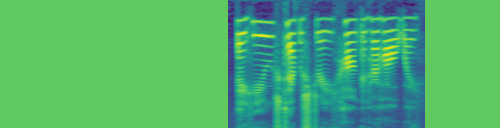

Channel 0.1 (128x500):


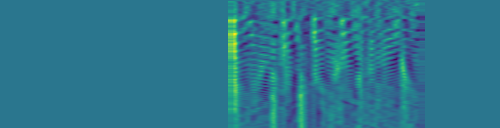

Channel 0.2 (128x500):


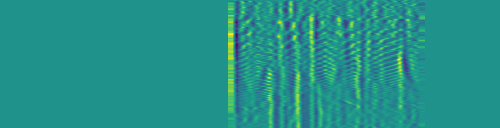

------------------------------------------------------------
File: /data/stt/data/timit/TRAIN/DR5/FCDR1/SI1186.WAV.wav
Total Length: 5.64 seconds
Number of Channels: 1
Label: Questions came to me from all sides about my world citizenship activities.



Channel 0.0 (128x500):


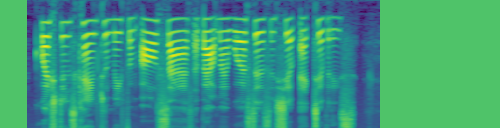

Channel 0.1 (128x500):


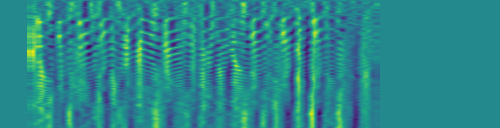

Channel 0.2 (128x500):


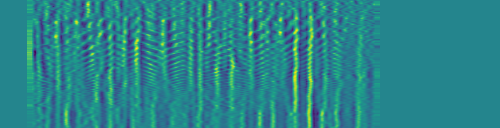

------------------------------------------------------------
File: /data/stt/data/timit/TRAIN/DR5/FCDR1/SI1816.WAV.wav
Total Length: 4.82 seconds
Number of Channels: 1
Label: Anyhow, it was high time the boy was salted.



Channel 0.0 (128x500):


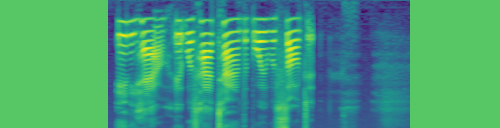

Channel 0.1 (128x500):


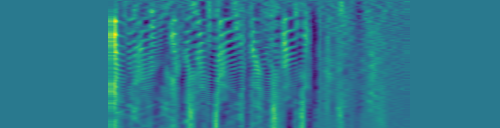

Channel 0.2 (128x500):


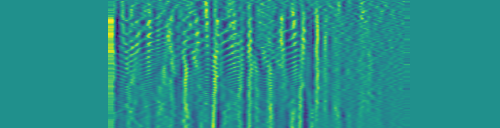

In [10]:
db.show_batch()

## End-To-End Model

In [300]:
context_size = 1024
device = "cuda:0"

In [301]:
class Language():
    def __init__(self, tokens):
        self.t2i = tokens
        self.i2t = {i: t for (t, i) in tokens.items()}
        
    def __len__(self):
        return len(self.t2i)
    
def stats(t):
    return t.mean(), t.std()

def n_params(m):
    return sum(p.numel() for p in m.parameters())

In [302]:
# grab some data
x = db.x[0].data.unsqueeze(0)
x.shape

torch.Size([1, 3, 128, 500])

In [303]:
# construct an alphabet
import string
tokens = {
    "<NIL>": 0,
    "<SOS>": 1,
    "<EOS>": 2,
    "<PAD>": 3,
}
possible_chars = string.ascii_lowercase + string.digits + string.punctuation 
tokens.update({_char: len(tokens) + _idx for (_idx, _char) in enumerate(possible_chars)})
lang = Language(tokens)

In [304]:
from audio.speech_models import SpeechModel
m = SpeechModel(context_size, lang, device=device)
_ = m.eval()
n_params(m)

60286344

In [307]:
%%time
res = m.decode_greedy(x, l=10)

context: torch.Size([1, 1024])
input_tokens: torch.Size([1, 10])
embedded_pos_enc: torch.Size([10, 1, 1024])
output_decoder: torch.Size([10, 1, 1024])
output_tokens: torch.Size([1, 10, 72])
[[[-3.679992 -4.353053 -3.422557 -5.354002 ... -4.985605 -5.352276 -3.84758  -4.393158]
  [-4.205168 -4.502827 -2.886927 -5.106203 ... -4.780272 -5.316304 -3.505139 -4.762571]
  [-4.205168 -4.502827 -2.886927 -5.106203 ... -4.780272 -5.316304 -3.505139 -4.762571]
  [-4.205168 -4.502827 -2.886927 -5.106203 ... -4.780272 -5.316304 -3.505139 -4.762571]
  ...
  [-4.205168 -4.502827 -2.886927 -5.106203 ... -4.780272 -5.316304 -3.505139 -4.762571]
  [-4.205168 -4.502827 -2.886927 -5.106203 ... -4.780272 -5.316304 -3.505139 -4.762571]
  [-4.205168 -4.502827 -2.886927 -5.106203 ... -4.780272 -5.316304 -3.505139 -4.762571]
  [-4.205168 -4.502827 -2.886927 -5.106203 ... -4.780272 -5.316304 -3.505139 -4.762571]]]
CPU times: user 14.7 ms, sys: 713 µs, total: 15.4 ms
Wall time: 13.6 ms


In [308]:
res

['><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS>']